In [165]:
import pandas as pd
import konlpy
import gensim

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import keras
import tensorflow as tf

### 1. 데이터 준비와 확인

In [166]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train : ", train_data.shape)
print("test  : ", test_data.shape)

train :  (150000, 3)
test  :  (50000, 3)


### 2. 데이터로더 구성

In [167]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    '''중복 제거, 결측값 제거, 토큰화, 불용어 제거, 사전 생성, 인덱싱하는 함수
    Args:
        train_data(pd.DataFrame): train data set
        test_data(pd.DataFrame): test data set
        num_words(int): 단어 수, default=10000
    '''
    ## 중복 제거
    train_data = train_data.drop_duplicates(subset=["document"])
    test_data = test_data.drop_duplicates(subset=["document"])
    
    ## 결측값 제거
    train_data = train_data.dropna(how="any")
    test_data = test_data.dropna(how="any")
    
    ## 토큰화 & 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    ## 사전 word_to_index 구성 <- train 데이터로만 진행!
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] ## <PAD>, <BOS>, <UNK>, <UNUSED>를 위한 인덱스 
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    ## 텍스트 스트링을 사전 인덱스 스트링으로 변환
    ## 오류 코드 ##
#     def wordlist_to_indexlist(wordlist):
#         return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
#     X_train = list(map(wordlist_to_indexlist, X_train))
#     X_test = list(map(wordlist_to_indexlist, X_test))

    ## 오류 수정 ##
    def train_wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
    
    def test_wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(train_wordlist_to_indexlist, X_train))
    X_test = list(map(test_wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [168]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [169]:
print("X train : ", len(X_train))
print("X test  : ", len(X_test))

X train :  146182
X test  :  49157


### 사전 word_to_index 추가 전처리

In [170]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [171]:
len(word_to_index)

10000

In [172]:
# word_to_index

In [173]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [174]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [175]:
# get_decoded_sentences(X_train, index_to_word)

In [176]:
# get_decoded_sentences(X_test, index_to_word)

### 오류 수정 과정
train set에서 decoding을 해보니 '재 `<UNK>`'와 같이 `<UNK>`가 사용되었다. 
따라서 사전을 구성할 때 수정해서 '재 `<UNUSED>`'로 나오도록 해야겠다. 

train set에는 `<UNUSED>`가 test set에는 `<UNK>`가 나오도록 수정하였다.

### 3. 모델 구성을 위한 데이터 분석 및 가공

In [177]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.round(np.sum(num_tokens < max_tokens) / len(num_tokens), 2)*100}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.0%가 maxlen 설정값 이내에 포함됩니다. 


In [178]:
X_train = keras.preprocessing.sequence.pad_sequences(
    X_train,
    value=word_to_index["<PAD>"],
    padding='pre', # post에 비해 높은 성능을 내는 pre를 사용
    maxlen=maxlen
)

X_test = keras.preprocessing.sequence.pad_sequences(
    X_test,
    value=word_to_index["<PAD>"],
    padding='pre', # post에 비해 높은 성능을 내는 pre를 사용
    maxlen=maxlen
)

In [179]:
print('1번째 문장 길이: ', len(X_train[0]))
print('2번째 문장 길이: ', len(X_train[1]))

1번째 문장 길이:  41
2번째 문장 길이:  41


### 4. 모델 구성 및 validation set 구성
1. lstm(32) -> dense(8)
2. lstm(32) with bidirectional -> dense(8)
3. gru(32) -> dense(8)

In [180]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [181]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

1. word_vector_dim 16 -> 30으로 수정

In [182]:
# model1 : lstm(32) -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.LSTM(32)(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model1 = keras.Model(inputs, outputs)

# model2 : lstm(32) with bi -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)

# model3 : gru(32) -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.GRU(32)(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model3 = keras.Model(inputs, outputs)

In [183]:
model1.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 41, 30)            300000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8064      
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 308,337
Trainable params: 308,337
Non-trainable params: 0
_________________________________________________________________


In [184]:
model2.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 41, 30)            300000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16128     
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 316,657
Trainable params: 316,657
Non-trainable params: 0
_________________________________________________________________


In [185]:
model3.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 41, 30)            300000    
_________________________________________________________________
gru_12 (GRU)                 (None, 32)                6144      
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 306,417
Trainable params: 306,417
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련 개시 & 6. Loss, Accuracy 그래프 시각화

In [186]:
epochs=20

In [187]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 7ms/step - loss: 0.4514 - accuracy: 0.7908 - val_loss: 0.3460 - val_accuracy: 0.8496
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3270 - accuracy: 0.8610 - val_loss: 0.3385 - val_accuracy: 0.8535
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3030 - accuracy: 0.8722 - val_loss: 0.3287 - val_accuracy: 0.8565
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2839 - accuracy: 0.8814 - val_loss: 0.3296 - val_accuracy: 0.8575
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2656 - accuracy: 0.8895 - val_loss: 0.3294 - val_accuracy: 0.8601
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2477 - accuracy: 0.8981 - val_loss: 0.3367 - val_accuracy: 0.8580
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2305 - accuracy: 0.9050 - val_loss: 0.3582 - val_accuracy: 0.8576
Epoch 

In [188]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.7480 - accuracy: 0.8400
[0.7480402588844299, 0.8399617671966553]


In [189]:
import matplotlib.pyplot as plt

def result_visualization(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

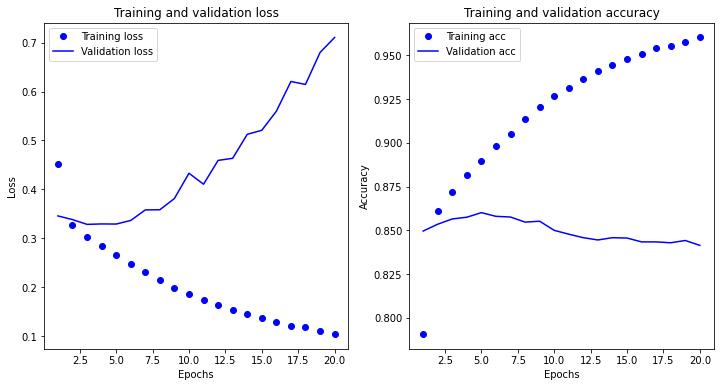

In [190]:
result_visualization(history1)

In [191]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 10ms/step - loss: 0.4429 - accuracy: 0.7940 - val_loss: 0.3592 - val_accuracy: 0.8374
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3313 - accuracy: 0.8582 - val_loss: 0.3386 - val_accuracy: 0.8514
Epoch 3/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3104 - accuracy: 0.8683 - val_loss: 0.3344 - val_accuracy: 0.8555
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2935 - accuracy: 0.8769 - val_loss: 0.3332 - val_accuracy: 0.8576
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2761 - accuracy: 0.8850 - val_loss: 0.3358 - val_accuracy: 0.8584
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2557 - accuracy: 0.8936 - val_loss: 0.3462 - val_accuracy: 0.8587
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2388 - accuracy: 0.9009 - val_loss: 0.3618 - val_accuracy: 0.8571
Epoch

In [192]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 4s - loss: 0.6480 - accuracy: 0.8404
[0.6480146050453186, 0.8403889536857605]


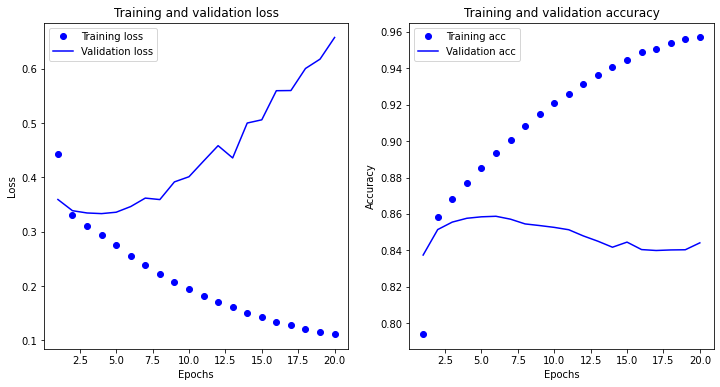

In [193]:
result_visualization(history2)

In [194]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 7ms/step - loss: 0.4565 - accuracy: 0.7806 - val_loss: 0.3479 - val_accuracy: 0.8506
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3350 - accuracy: 0.8576 - val_loss: 0.3434 - val_accuracy: 0.8513
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3172 - accuracy: 0.8681 - val_loss: 0.3437 - val_accuracy: 0.8511
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3040 - accuracy: 0.8742 - val_loss: 0.3375 - val_accuracy: 0.8523
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2912 - accuracy: 0.8799 - val_loss: 0.3286 - val_accuracy: 0.8562
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2747 - accuracy: 0.8874 - val_loss: 0.3277 - val_accuracy: 0.8573
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2578 - accuracy: 0.8952 - val_loss: 0.3330 - val_accuracy: 0.8590
Epoch 

In [195]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 3s - loss: 0.5775 - accuracy: 0.8389
[0.5775049924850464, 0.8388835787773132]


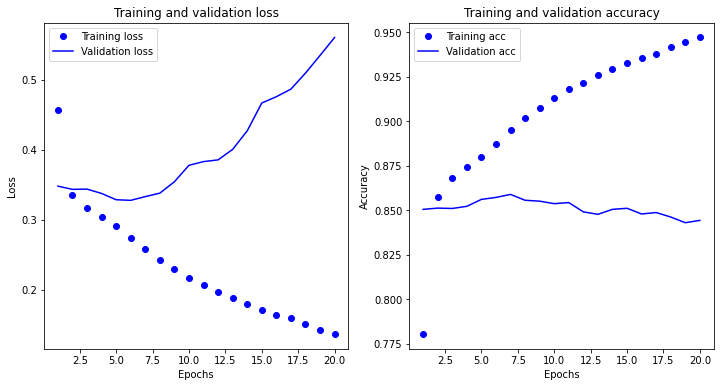

In [196]:
result_visualization(history3)

### 7. 학습된 Embedding 레이어 분석

In [197]:
embedding_layer = model3.layers[1]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 30)


### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [198]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [199]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [200]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [202]:
# model4 : embedding -> gru(32) -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(
    vocab_size, 
    word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen, 
    trainable=True
)(inputs)
x = keras.layers.GRU(64, return_sequences=True)(x)
x = keras.layers.GRU(64, return_sequences=False)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model4 = keras.Model(inputs, outputs)

In [203]:
model4.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
gru_13 (GRU)                 (None, 41, 64)            31872     
_________________________________________________________________
gru_14 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dense_48 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_49 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0  

In [205]:
# 학습의 진행
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 6s 12ms/step - loss: 0.4840 - accuracy: 0.7682 - val_loss: 0.3728 - val_accuracy: 0.8254
Epoch 2/20
266/266 [==============================] - 3s 9ms/step - loss: 0.3620 - accuracy: 0.8467 - val_loss: 0.3299 - val_accuracy: 0.8543
Epoch 3/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3191 - accuracy: 0.8685 - val_loss: 0.3130 - val_accuracy: 0.8615
Epoch 4/20
266/266 [==============================] - 2s 9ms/step - loss: 0.2954 - accuracy: 0.8800 - val_loss: 0.3070 - val_accuracy: 0.8642
Epoch 5/20
266/266 [==============================] - 3s 9ms/step - loss: 0.2758 - accuracy: 0.8895 - val_loss: 0.3068 - val_accuracy: 0.8659
Epoch 6/20
266/266 [==============================] - 3s 9ms/step - loss: 0.2584 - accuracy: 0.8981 - val_loss: 0.3100 - val_accuracy: 0.8639
Epoch 7/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2426 - accuracy: 0.9049 - val_loss: 0.3204 - val_accuracy: 0.8595
Epoc

In [206]:
# 테스트셋을 통한 모델 평가
results4 = model4.evaluate(X_test, y_test, verbose=2)

print(results4)

1537/1537 - 4s - loss: 0.7646 - accuracy: 0.8504
[0.7646042704582214, 0.8503977060317993]


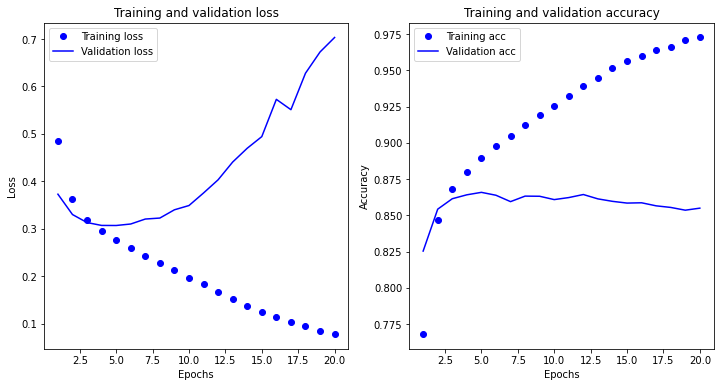

In [207]:
result_visualization(history4)

### 회고
자연어 처리의 여러 모델을 사용해볼 수 있어 좋았다. 
여러가지 전처리를 추가하는 실험을 진행하면 성능이 더 오를까??